# Pipeline

In this example we use 2MASS images in K' of M31 covering approximately 10 sq degs.

## Getting 2MASS images

In [1]:
# 0 Get images from IRSA
from wfiskymatch.scripts import get2MASSfiles
object = 'M31'
size = 3.162 # square of 10 sq degs
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
get2MASSfiles(object,size=size,outdir=outdir)


Imported:  370  files


## Healpix projection

In [14]:
# 1  Healpix reproject
from wfiskymatch.scripts import tarfile2healpix
import tarfile, os, gzip
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
tarfile2healpix(object, outdir=outdir)

Files will be in  /Users/dfadda/Roman/BgrMatch/2MASS/M31_h5


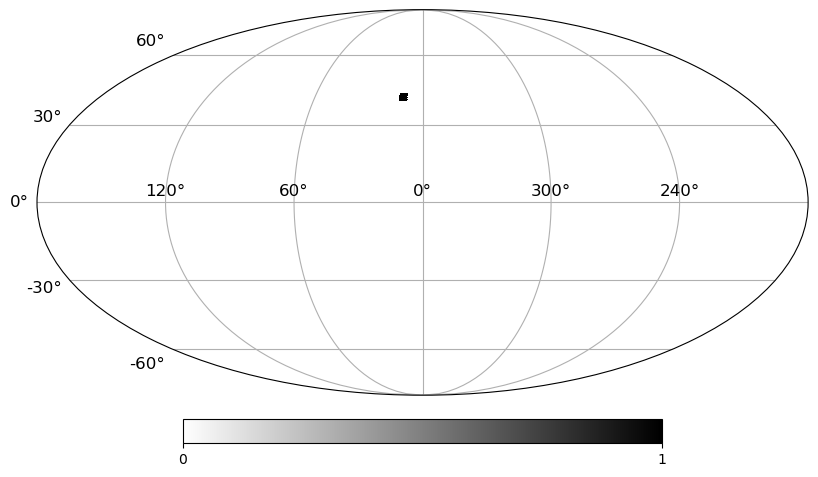

In [3]:
# check: show the coverage in Mollweide projection
from wfiskymatch.scripts import plotcoverage
from glob import glob as gb
import os
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
outdirh5 = os.path.join(outdir,object+'_h5')
files = sorted(gb(os.path.join(outdirh5,'*.h5')))
plotcoverage(files)

## Clustering

This step allows one to separate groups of overlapping images in a set of images.
It makes sense to compute the matching only when a group of images is connected by overlaps.

The example shows two separate fields in the same list. After computing the overlaps of their images it is possible to separate the two groups of images.

In [40]:
# Getting a second set close
from wfiskymatch.scripts import get2MASSfiles
#object = 'IC10'
#object = 'NGC147'
object = 'M33'
size = 3.162
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
get2MASSfiles(object,size=size,outdir=outdir)


Imported:  374  files


In [41]:
from wfiskymatch.scripts import tarfile2healpix
import tarfile, os, gzip
#object = 'IC10'
#object = 'NGC147'
#object = 'M33'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
tarfile2healpix(object, outdir=outdir)

Files will be in  /Users/dfadda/Roman/BgrMatch/2MASS/M33_h5


In [1]:
# Computing overlap sparse matrix
from wfiskymatch.tools import computeOverlaps
from glob import glob as gb

files = sorted(gb('/Users/dfadda/Roman/BgrMatch/2MASS/*_h5/*h5'))
overlap = computeOverlaps(files)

Filling percentage:  0.4815843370225694 %


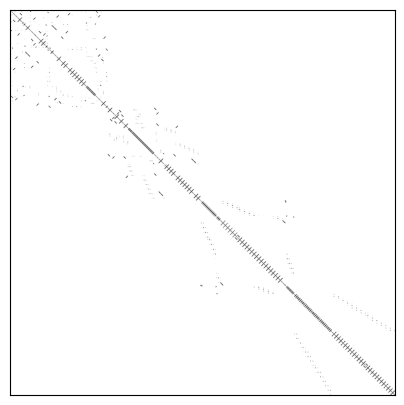

In [3]:
import matplotlib.pyplot as plt
import numpy as np
array2d = overlap.toarray()
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(array2d,cmap='gray_r',vmin=0,vmax=1)
plt.xticks([]) 
plt.yticks([]) 
#plt.colorbar()
n = np.sum(array2d)
nx,ny = np.shape(array2d)
print('Filling percentage: ', n/(nx*ny) * 100,'%')
#fig.savefig('sparsematrix_m31.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

In [4]:
# Connected groups: group of images with overlaps

from scipy.sparse.csgraph import connected_components
nb_clusters, labels = connected_components(overlap)
print(nb_clusters,' clusters')
print(labels)

4  clusters
[0 0 0 ... 3 3 3]


In [5]:
# Figure with connected groups
connected = overlap.copy()

for i,l in enumerate(labels):
    idx = connected.indices == i
    connected.data[idx] = l+1

In [6]:
print(np.unique(connected.data))

[1 2 3 4]


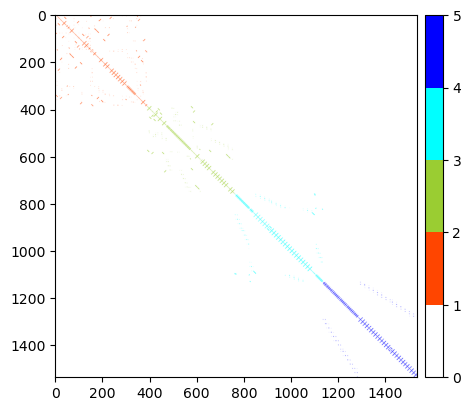

In [7]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
colors = ['white', 'orangered', 
                  'yellowgreen','cyan','blue','violet','purple','black']
cmap_name = 'my_list'
maxcov = 5
cmap = LinearSegmentedColormap.from_list(cmap_name, colors[:maxcov], N=maxcov)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ima = ax.imshow(connected.toarray(),cmap=cmap,vmin=0,vmax=5)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(ima, cax=cax)



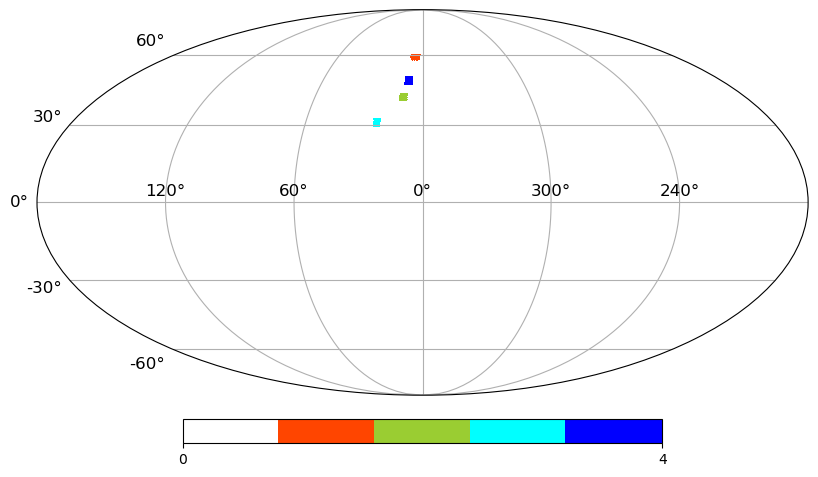

In [8]:
from wfiskymatch.scripts import plotcoverage
from glob import glob as gb
from matplotlib.colors import LinearSegmentedColormap


#plotcoverage(files,labels,cmap='Pastel1_r')
plotcoverage(files,labels,cmap=cmap)

## Computing offsets

In [3]:
# 2 Compute the offsets
# compute offsets
from wfiskymatch.tools import pixmatch
from glob import glob as gb
import os
import time

start  = time.time()
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
h5outdir = os.path.join(outdir,object+'_h5')
files = sorted(gb(os.path.join(h5outdir,'*.h5')))
offsets = pixmatch(files, outfile=outdir+object+'_offsets')
print('matched {0:d} images in {1:.2f} s'.format(len(files),time.time()-start))

matched 370 images in 7.45 s


M31_000


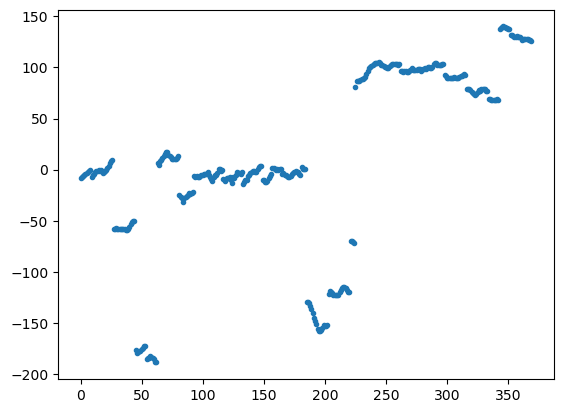

In [26]:
# check: plot the offsets
import matplotlib.pyplot as plt
import h5py
import os
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
h5file = os.path.join(outdir, object+'_offsets.h5')
with h5py.File(h5file, 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]    

print(files[0].decode('UTF-8'))
plt.plot(offsets,'.');

## Generating mosaic

In [27]:
# 3 Coaddition using the offsets
from wfiskymatch.scripts import makeMosaic
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'
# pixmatch
makeMosaic(object, outdir, offsetfile=True, savefootprint=True)

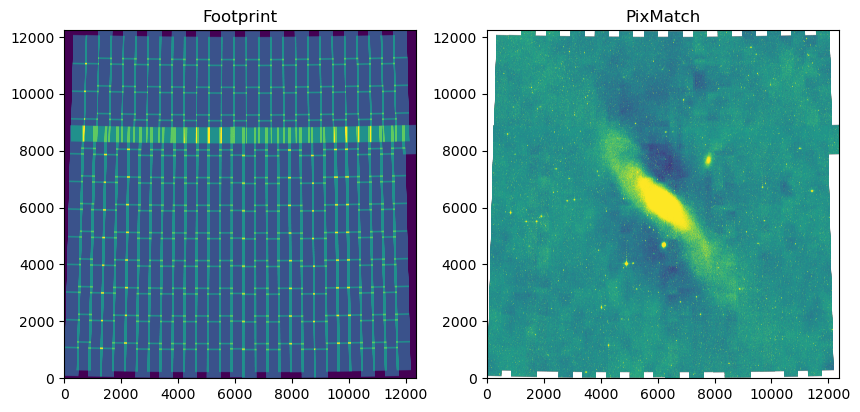

In [28]:
# check: show the result
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/2MASS/'

fig, axs = plt.subplots(1, 2, figsize=(10,6))
with fits.open(outdir+object+'_footprint.fits') as f:
    footprint = f[0].data
im0 = axs[0].imshow(footprint, origin='lower')
axs[0].set_title('Footprint')
d = 5
with fits.open(outdir+object+'_wfiskymatch.fits') as f:
    array = f[0].data
im2 = axs[1].imshow(array-np.nanmedian(array), origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('PixMatch')
plt.show()


In [84]:
# Size pixel and tile
import numpy as np
n = 2**16
pixsize = np.sqrt(4 * np.pi / (12 * n * n)) 
pixsize = np.rad2deg (pixsize) * 3600
print('pixel ', pixsize, ' arcsec')
n = 2**10
pixsize = np.sqrt(4 * np.pi / (12 * n * n)) 
pixsize = np.rad2deg (pixsize) * 60
print('tile ', pixsize, ' arcmin')

pixel  3.220768511078818  arcsec
tile  3.435486411817406  arcmin


In [18]:
# Using a simulated WFI image
from wfiskymatch.tools import asdf2healpix

filepath = '/Users/dfadda/Roman/stpreview/Data/MAST_2025-03-10T20_29_06.239Z/Roman/'
file = 'r0000101001001001001_0002_wfi07_cal.asdf'

asdf2healpix(filepath+file, filepath)

filename is  r0000101001001001001_0002_wfi07_cal
saving in /Users/dfadda/Roman/stpreview/Data/MAST_2025-03-10T20_29_06.239Z/Roman/r0000101001001001001_0002_wfi07_cal.h5


In [17]:
# Size original and healpix file
import os
filepath = '/Users/dfadda/Roman/stpreview/Data/MAST_2025-03-10T20_29_06.239Z/Roman/'
file = 'r0000101001001001001_0002_wfi07_cal.asdf'
size = os.path.getsize(filepath+file)
Kb = 2**10
Mb = 2**20
print('Size is: ', size/Mb,' MB')
file = 'r0000101001001001001_0002_wfi07_cal.h5'
size_h5 = os.path.getsize(filepath+file)
Kb = 2**10
Mb = 2**20
print('Size is: ', size_h5/Mb, ' MB')
print('Compression factor is: {0:.2f} %'.format(size_h5/size * 100))


Size is:  385.9301176071167  MB
Size is:  0.17217254638671875  MB
Compression factor is: 0.04 %


## Rotating Healpix maps

It could be of interest to show Galactic surveys in galactic coordinates instead of equatorial coordinates.
There is a simple method to do this, see the tutorial https://www.zonca.dev/posts/2021-03-11-rotate-maps-healpy.html